In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

In [2]:
def save_performance_table(df, metric, output_dir, fname):
    
    os.makedirs(output_dir, exist_ok=True)
    
    grouped_df = df.groupby(['subject_id', 'montage', 'window']).mean()[[metric]]
    grouped_df.reset_index(inplace=True)
    new_df = pd.DataFrame()
    for subject_id in grouped_df.subject_id.unique():
        subset = (grouped_df[grouped_df['subject_id'] == subject_id].copy()).loc[:, ['window', 'montage', metric]].reset_index(drop=True)
        if 'window' in new_df.columns:
            subset = subset.loc[:, [metric]]
        subset.rename({metric: subject_id}, axis=1, inplace=True)
        new_df = pd.concat([new_df, subset], axis=1)
        new_df.groupby(['window', 'montage']).mean().reset_index().to_csv(os.path.join(output_dir, fname), index=False)

# Linear SVM Experiments

## PC

In [26]:
root_dir = os.path.join(constants.RESULTS_DIR, 'motor_LR', 'baseline', 'linear_svm', 'pc', 'bandpass_only')
output_table_dir = os.path.join(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'acc_tables', 'baseline', 'linear_svm', 'pc', 'bandpass_only'))
fname = 'no_selection_test_accuracy_table.csv'

exp_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

df = pd.DataFrame()

for d in exp_dirs:
    if d.startswith('no_select'):
        window = d.split('_')[-1]
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, 'None_results.parquet'))
            temp.loc[:, 'selection_method'] = 'None'
            temp.loc[:, 'window'] = window
        except:
            continue
    else:
        selection_method = d.split('_')[-1]
        window = d.split('_')[2]
        if selection_method in ['mi', 'pca', 'rfe', 'sfs']:
            selection_method = selection_method.upper()
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, f'{selection_method}_results.parquet'))
            temp.loc[:, 'selection_method'] = selection_method
            temp.loc[:, 'window'] = window
        except:
            continue
    df = df.append(temp, ignore_index=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_cols = [f'Train {m}' for m in metrics]
valid_cols = [f'Valid {m}' for m in metrics]
test_cols = [f'Test {m}' for m in metrics]

# Sort by column values
window_sorter = ['all', '0', '1', '2', '3', '4', '5', '6', '7']
select_sorter = ['None', 'PCA', 'MI']
df.window = df.window.astype('category')
df.window.cat.set_categories(window_sorter, inplace=True)
df.selection_method = df.selection_method.astype('category')
df.selection_method.cat.set_categories(select_sorter, inplace=True)
df.sort_values(['window', 'selection_method'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [27]:
output_df = df.groupby(['window', 'selection_method']).mean()[test_cols].round(3)
output_df

Test Accuracy  Test Precision  Test Recall  Test F1
window selection_method                                                     
all    None                      0.495           0.495        0.495    0.492
       PCA                       0.491           0.491        0.491    0.488
       MI                        0.490           0.490        0.490    0.487
0      None                      0.489           0.489        0.489    0.485
       PCA                       0.494           0.494        0.494    0.491
       MI                        0.490           0.490        0.490    0.487
1      None                      0.492           0.491        0.492    0.488
       PCA                       0.491           0.491        0.491    0.488
       MI                        0.494           0.494        0.494    0.491
2      None                      0.500           0.500        0.500    0.497
       PCA                       0.502           0.502        0.502    0.498
       MI                        0.496           0.496        0.496    0.492
3      None                      0.496           0.496        0.496    0.492
       PCA                       0.494           0.494        0.494    0.490
       MI                        0.498           0.497        0.497    0.494
4      None                      0.495           0.495        0.495    0.492
       PCA                       0.499           0.500        0.499    0.496
       MI                        0.498           0.498        0.498    0.495
5      None                      0.501           0.501        0.501    0.498
       PCA                       0.505           0.505        0.505    0.502
       MI                        0.496           0.496        0.496    0.492
6      None                      0.494           0.494        0.494    0.490
       PCA                       0.490           0.490        0.490    0.487
       MI                        0.490           0.490        0.490    0.487
7      None                      0.489           0.489        0.489    0.486
       PCA                       0.491           0.491        0.491    0.488
       MI                        0.488           0.488        0.488    0.485

In [9]:
output_df.reset_index(inplace=True)
print(output_df.to_latex(index=False,
                         header=['Window', 'Montage', 'Accuracy', 'Precision', 'Recall', 'F1']))

\begin{tabular}{llrrrr}
\toprule
Window & Montage & Accuracy & Precision & Recall &     F1 \\
\midrule
   all &    None &    0.495 &     0.495 &  0.495 &  0.492 \\
   all &     PCA &    0.491 &     0.491 &  0.491 &  0.488 \\
   all &      MI &    0.490 &     0.490 &  0.490 &  0.487 \\
     0 &    None &    0.489 &     0.489 &  0.489 &  0.485 \\
     0 &     PCA &    0.494 &     0.494 &  0.494 &  0.491 \\
     0 &      MI &    0.490 &     0.490 &  0.490 &  0.487 \\
     1 &    None &    0.492 &     0.491 &  0.492 &  0.488 \\
     1 &     PCA &    0.491 &     0.491 &  0.491 &  0.488 \\
     1 &      MI &    0.494 &     0.494 &  0.494 &  0.491 \\
     2 &    None &    0.500 &     0.500 &  0.500 &  0.497 \\
     2 &     PCA &    0.502 &     0.502 &  0.502 &  0.498 \\
     2 &      MI &    0.496 &     0.496 &  0.496 &  0.492 \\
     3 &    None &    0.496 &     0.496 &  0.496 &  0.492 \\
     3 &     PCA &    0.494 &     0.494 &  0.494 &  0.490 \\
     3 &      MI &    0.498 &     0.497 &  

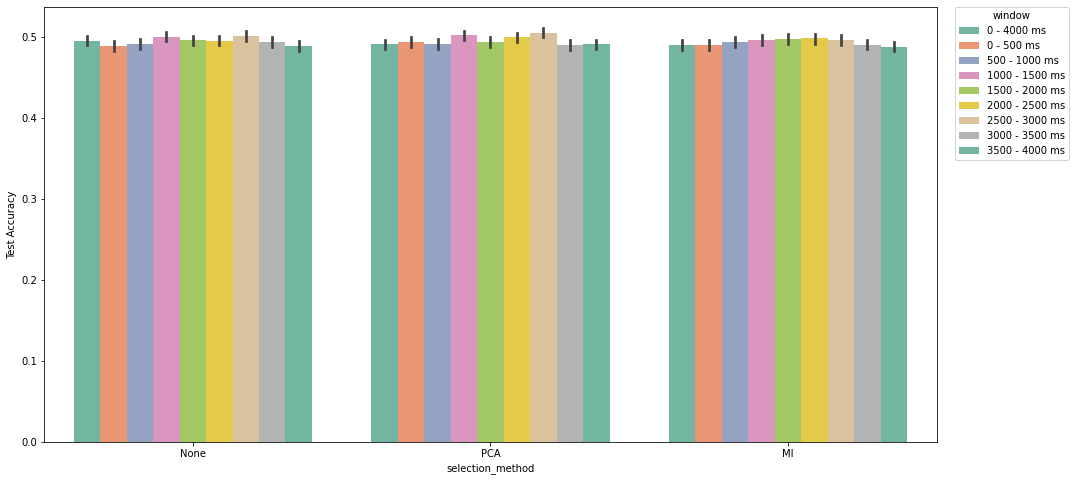

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
window_mapping = {
    'all': '0 - 4000 ms',
    '0': '0 - 500 ms',
    '1': '500 - 1000 ms',
    '2': '1000 - 1500 ms',
    '3': '1500 - 2000 ms',
    '4': '2000 - 2500 ms',
    '5': '2500 - 3000 ms',
    '6': '3000 - 3500 ms',
    '7': '3500 - 4000 ms'
}
plot_df = df.copy()
plot_df['window'].replace(window_mapping, inplace=True)

sns.barplot(data=plot_df, x='selection_method', y='Test Accuracy', hue='window', palette='Set2', ax=ax)
plt.legend(title='window', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);

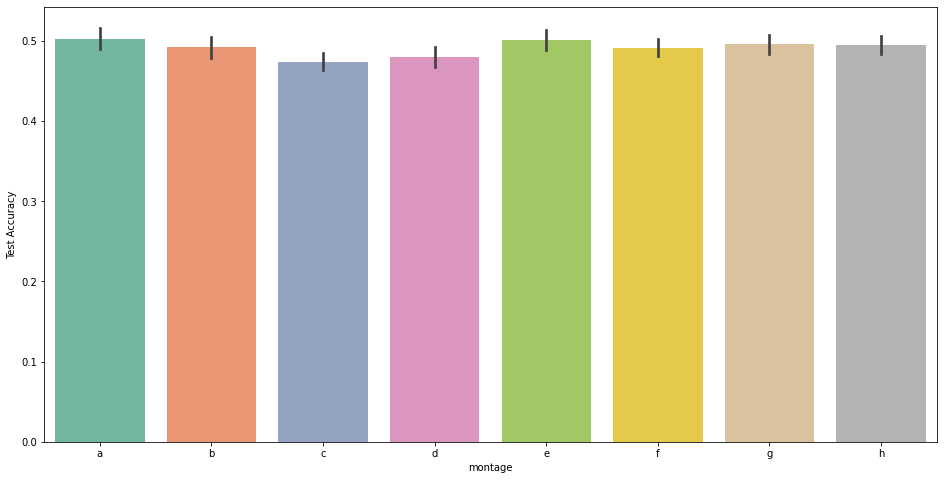

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], x='montage', y='Test Accuracy', palette='Set2', ax=ax);

In [7]:
save_performance_table(df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], 'Test Accuracy', output_table_dir, fname)

## RS

In [23]:
root_dir = os.path.join(constants.RESULTS_DIR, 'motor_LR', 'baseline', 'linear_svm', 'rs', 'bandpass_only')
output_table_dir = os.path.join(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'acc_tables', 'baseline', 'linear_svm', 'rs', 'bandpass_only'))
fname = 'no_selection_test_accuracy_table.csv'

exp_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

df = pd.DataFrame()

for d in exp_dirs:
    if d.startswith('no_select'):
        window = d.split('_')[-1]
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, 'None_results.parquet'))
            temp.loc[:, 'selection_method'] = 'None'
            temp.loc[:, 'window'] = window
        except:
            continue
    else:
        selection_method = d.split('_')[-1]
        window = d.split('_')[2]
        if selection_method in ['mi', 'pca', 'rfe', 'sfs']:
            selection_method = selection_method.upper()
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, f'{selection_method}_results.parquet'))
            temp.loc[:, 'selection_method'] = selection_method
            temp.loc[:, 'window'] = window
        except:
            continue
    df = df.append(temp, ignore_index=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_cols = [f'Train {m}' for m in metrics]
valid_cols = [f'Valid {m}' for m in metrics]
test_cols = [f'Test {m}' for m in metrics]

# Sort by column values
window_sorter = ['all', '0', '1', '2', '3', '4', '5', '6', '7']
select_sorter = ['None', 'PCA', 'MI']
df.window = df.window.astype('category')
df.window.cat.set_categories(window_sorter, inplace=True)
df.selection_method = df.selection_method.astype('category')
df.selection_method.cat.set_categories(select_sorter, inplace=True)
df.sort_values(['window', 'selection_method'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [24]:
output_df = df.groupby(['window', 'selection_method']).mean()[test_cols].round(3)
output_df

Test Accuracy  Test Precision  Test Recall  Test F1
window selection_method                                                     
all    None                      0.492           0.491        0.492    0.488
       PCA                       0.493           0.493        0.493    0.490
       MI                        0.489           0.488        0.489    0.484
0      None                      0.492           0.492        0.492    0.489
       PCA                       0.493           0.493        0.493    0.490
       MI                        0.496           0.496        0.496    0.492
1      None                      0.496           0.495        0.496    0.492
       PCA                       0.498           0.498        0.498    0.495
       MI                        0.493           0.492        0.493    0.489
2      None                      0.491           0.490        0.491    0.487
       PCA                       0.489           0.489        0.489    0.486
       MI                        0.492           0.492        0.492    0.489
3      None                      0.494           0.494        0.494    0.491
       PCA                       0.497           0.497        0.497    0.494
       MI                        0.494           0.493        0.493    0.490
4      None                      0.497           0.497        0.497    0.493
       PCA                       0.496           0.496        0.496    0.492
       MI                        0.500           0.500        0.499    0.496
5      None                      0.502           0.502        0.502    0.498
       PCA                       0.502           0.502        0.502    0.498
       MI                        0.494           0.493        0.494    0.490
6      None                      0.489           0.489        0.489    0.485
       PCA                       0.491           0.491        0.491    0.488
       MI                        0.487           0.487        0.487    0.483
7      None                      0.498           0.498        0.498    0.495
       PCA                       0.498           0.498        0.498    0.494
       MI                        0.496           0.495        0.496    0.491

In [25]:
output_df.reset_index(inplace=True)
print(output_df.to_latex(index=False,
                         header=['Window', 'Montage', 'Accuracy', 'Precision', 'Recall', 'F1']))

\begin{tabular}{llrrrr}
\toprule
Window & Montage & Accuracy & Precision & Recall &     F1 \\
\midrule
   all &    None &    0.492 &     0.491 &  0.492 &  0.488 \\
   all &     PCA &    0.493 &     0.493 &  0.493 &  0.490 \\
   all &      MI &    0.489 &     0.488 &  0.489 &  0.484 \\
     0 &    None &    0.492 &     0.492 &  0.492 &  0.489 \\
     0 &     PCA &    0.493 &     0.493 &  0.493 &  0.490 \\
     0 &      MI &    0.496 &     0.496 &  0.496 &  0.492 \\
     1 &    None &    0.496 &     0.495 &  0.496 &  0.492 \\
     1 &     PCA &    0.498 &     0.498 &  0.498 &  0.495 \\
     1 &      MI &    0.493 &     0.492 &  0.493 &  0.489 \\
     2 &    None &    0.491 &     0.490 &  0.491 &  0.487 \\
     2 &     PCA &    0.489 &     0.489 &  0.489 &  0.486 \\
     2 &      MI &    0.492 &     0.492 &  0.492 &  0.489 \\
     3 &    None &    0.494 &     0.494 &  0.494 &  0.491 \\
     3 &     PCA &    0.497 &     0.497 &  0.497 &  0.494 \\
     3 &      MI &    0.494 &     0.493 &  

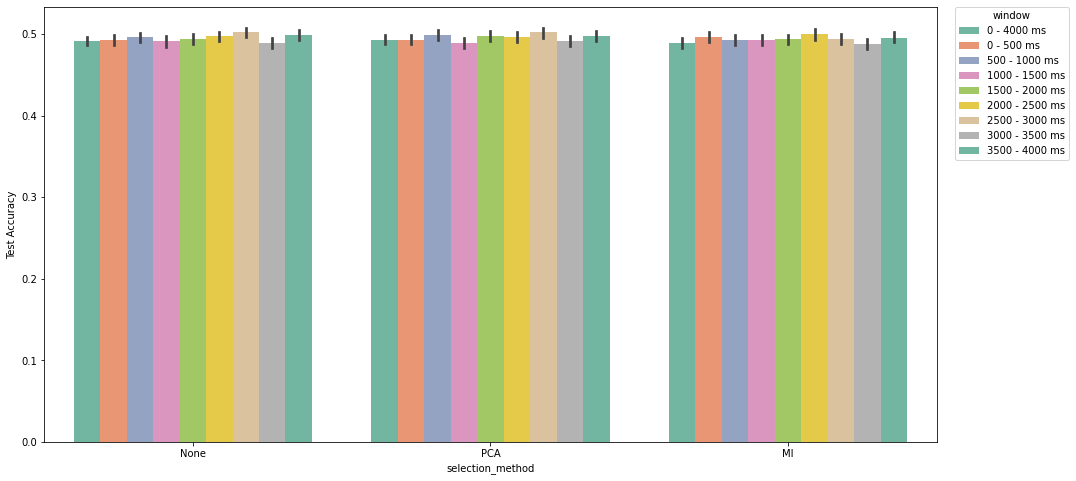

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
window_mapping = {
    'all': '0 - 4000 ms',
    '0': '0 - 500 ms',
    '1': '500 - 1000 ms',
    '2': '1000 - 1500 ms',
    '3': '1500 - 2000 ms',
    '4': '2000 - 2500 ms',
    '5': '2500 - 3000 ms',
    '6': '3000 - 3500 ms',
    '7': '3500 - 4000 ms'
}
plot_df = df.copy()
plot_df['window'].replace(window_mapping, inplace=True)

sns.barplot(data=plot_df, x='selection_method', y='Test Accuracy', hue='window', palette='Set2', ax=ax)
plt.legend(title='window', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);

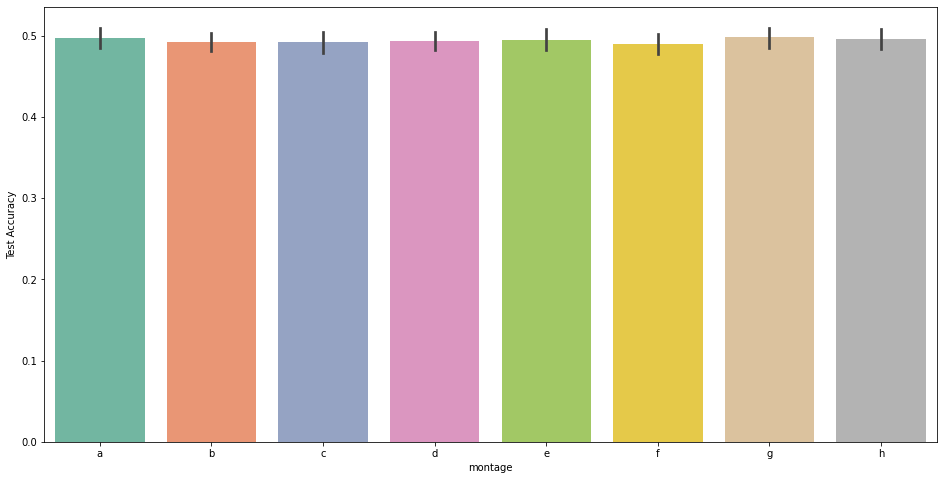

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], x='montage', y='Test Accuracy', palette='Set2', ax=ax);

In [9]:
save_performance_table(df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], 'Test Accuracy', output_table_dir, fname)

# RBF SVM Experiments

## PC

In [10]:
root_dir = os.path.join(constants.RESULTS_DIR, 'motor_LR', 'baseline', 'rbf_svm', 'pc', 'bandpass_only')
output_table_dir = os.path.join(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'acc_tables', 'baseline', 'rbf_svm', 'pc', 'bandpass_only'))
fname = 'no_selection_test_accuracy_table.csv'

exp_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

df = pd.DataFrame()

for d in exp_dirs:
    if d.startswith('no_select'):
        window = d.split('_')[-1]
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, 'None_results.parquet'))
            temp.loc[:, 'selection_method'] = 'None'
            temp.loc[:, 'window'] = window
        except:
            continue
    else:
        selection_method = d.split('_')[-1]
        window = d.split('_')[2]
        if selection_method in ['mi', 'pca', 'rfe', 'sfs']:
            selection_method = selection_method.upper()
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, f'{selection_method}_results.parquet'))
            temp.loc[:, 'selection_method'] = selection_method
            temp.loc[:, 'window'] = window
        except:
            continue
    df = df.append(temp, ignore_index=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_cols = [f'Train {m}' for m in metrics]
valid_cols = [f'Valid {m}' for m in metrics]
test_cols = [f'Test {m}' for m in metrics]

# Sort by column values
window_sorter = ['all', '0', '1', '2', '3', '4', '5', '6', '7']
select_sorter = ['None', 'PCA', 'MI']
df.window = df.window.astype('category')
df.window.cat.set_categories(window_sorter, inplace=True)
df.selection_method = df.selection_method.astype('category')
df.selection_method.cat.set_categories(select_sorter, inplace=True)
df.sort_values(['window', 'selection_method'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
df.groupby(['window', 'selection_method']).mean()[test_cols]

Test Accuracy  Test Precision  Test Recall   Test F1
window selection_method                                                      
all    None                   0.472689        0.402038     0.470326  0.396405
       PCA                    0.462864        0.458413     0.462454  0.450465
       MI                     0.480905        0.417483     0.478544  0.412334
0      None                   0.484066        0.480720     0.483053  0.468565
       PCA                    0.485870        0.484054     0.485228  0.478462
       MI                     0.489681        0.488027     0.489075  0.471873
1      None                   0.486444        0.481548     0.485605  0.470252
       PCA                    0.490055        0.488477     0.489636  0.481765
       MI                     0.485973        0.483176     0.485307  0.467070
2      None                   0.493613        0.491256     0.492846  0.478372
       PCA                    0.493264        0.491511     0.492773  0.485264
       MI                     0.494621        0.492115     0.493960  0.477643
3      None                   0.481175        0.478218     0.480344  0.465321
       PCA                    0.483453        0.482241     0.483012  0.475476
       MI                     0.487182        0.483991     0.486487  0.471346
4      None                   0.486777        0.484478     0.486001  0.469923
       PCA                    0.485860        0.484738     0.485442  0.477963
       MI                     0.490467        0.487476     0.489739  0.471828
5      None                   0.496230        0.495097     0.495305  0.478451
       PCA                    0.494662        0.493335     0.494157  0.485744
       MI                     0.493663        0.491185     0.492630  0.474608
6      None                   0.483876        0.479781     0.483350  0.467222
       PCA                    0.485924        0.483075     0.485555  0.476563
       MI                     0.494346        0.489720     0.493516  0.472980
7      None                   0.483118        0.480902     0.482492  0.469030
       PCA                    0.482547        0.481670     0.482244  0.475037
       MI                     0.491424        0.487738     0.490897  0.472371

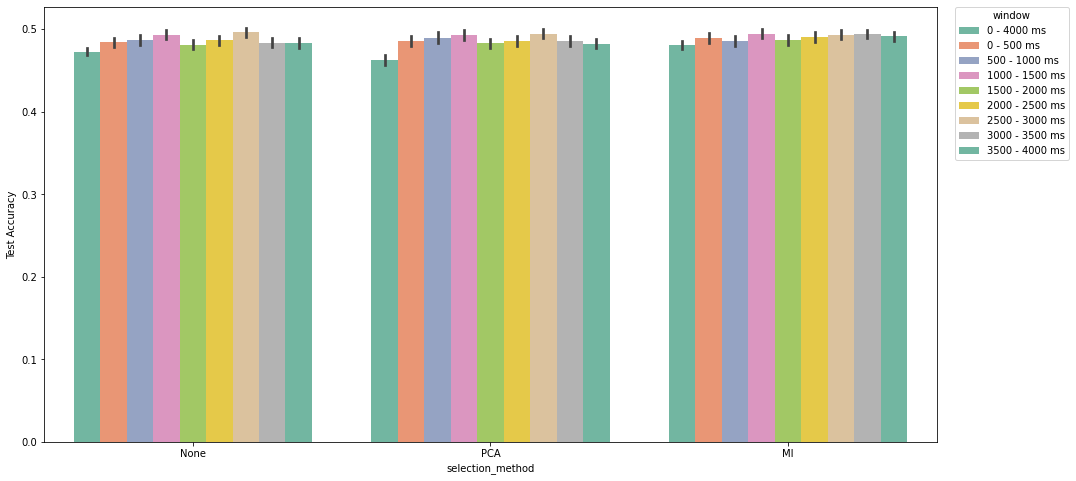

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
window_mapping = {
    'all': '0 - 4000 ms',
    '0': '0 - 500 ms',
    '1': '500 - 1000 ms',
    '2': '1000 - 1500 ms',
    '3': '1500 - 2000 ms',
    '4': '2000 - 2500 ms',
    '5': '2500 - 3000 ms',
    '6': '3000 - 3500 ms',
    '7': '3500 - 4000 ms'
}
plot_df = df.copy()
plot_df['window'].replace(window_mapping, inplace=True)

sns.barplot(data=plot_df, x='selection_method', y='Test Accuracy', hue='window', palette='Set2', ax=ax)
plt.legend(title='window', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);

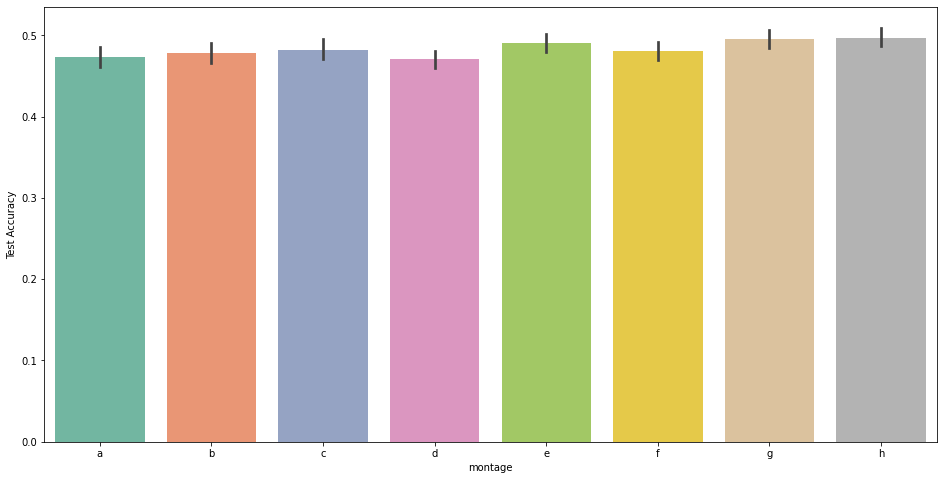

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], x='montage', y='Test Accuracy', palette='Set2', ax=ax);

In [7]:
save_performance_table(df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], 'Test Accuracy', output_table_dir, fname)

## RS

In [16]:
root_dir = os.path.join(constants.RESULTS_DIR, 'motor_LR', 'baseline', 'rbf_svm', 'rs', 'bandpass_only')
output_table_dir = os.path.join(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'acc_tables', 'baseline', 'rbf_svm', 'rs'))
fname = 'no_selection_test_accuracy_table.csv'

exp_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

df = pd.DataFrame()

for d in exp_dirs:
    if d.startswith('no_select'):
        window = d.split('_')[-1]
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, 'None_results.parquet'))
            temp.loc[:, 'selection_method'] = 'None'
            temp.loc[:, 'window'] = window
        except:
            continue
    else:
        selection_method = d.split('_')[-1]
        window = d.split('_')[2]
        if selection_method in ['mi', 'pca', 'rfe', 'sfs']:
            selection_method = selection_method.upper()
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, f'{selection_method}_results.parquet'))
            temp.loc[:, 'selection_method'] = selection_method
            temp.loc[:, 'window'] = window
        except:
            continue
    df = df.append(temp, ignore_index=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_cols = [f'Train {m}' for m in metrics]
valid_cols = [f'Valid {m}' for m in metrics]
test_cols = [f'Test {m}' for m in metrics]

# Sort by column values
window_sorter = ['all', '0', '1', '2', '3', '4', '5', '6', '7']
select_sorter = ['None', 'PCA', 'MI']
df.window = df.window.astype('category')
df.window.cat.set_categories(window_sorter, inplace=True)
df.selection_method = df.selection_method.astype('category')
df.selection_method.cat.set_categories(select_sorter, inplace=True)
df.sort_values(['window', 'selection_method'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
df.groupby(['window', 'selection_method']).mean()[test_cols].round(3)

Test Accuracy  Test Precision  Test Recall  Test F1
window selection_method                                                     
all    None                      0.478           0.394        0.474    0.390
       PCA                       0.466           0.459        0.465    0.452
       MI                        0.482           0.407        0.477    0.406
0      None                      0.485           0.476        0.483    0.463
       PCA                       0.485           0.481        0.484    0.475
       MI                        0.490           0.482        0.488    0.467
1      None                      0.501           0.499        0.499    0.482
       PCA                       0.498           0.496        0.497    0.489
       MI                        0.502           0.499        0.501    0.483
2      None                      0.492           0.487        0.491    0.473
       PCA                       0.495           0.492        0.494    0.485
       MI                        0.498           0.494        0.497    0.477
3      None                      0.487           0.482        0.486    0.469
       PCA                       0.490           0.489        0.489    0.481
       MI                        0.488           0.484        0.487    0.469
4      None                      0.498           0.495        0.497    0.478
       PCA                       0.496           0.495        0.495    0.486
       MI                        0.494           0.484        0.492    0.468
5      None                      0.494           0.489        0.492    0.472
       PCA                       0.495           0.493        0.494    0.484
       MI                        0.498           0.496        0.497    0.478
6      None                      0.488           0.483        0.487    0.471
       PCA                       0.487           0.484        0.486    0.477
       MI                        0.488           0.480        0.487    0.467
7      None                      0.485           0.481        0.484    0.465
       PCA                       0.488           0.487        0.487    0.479
       MI                        0.489           0.481        0.487    0.466

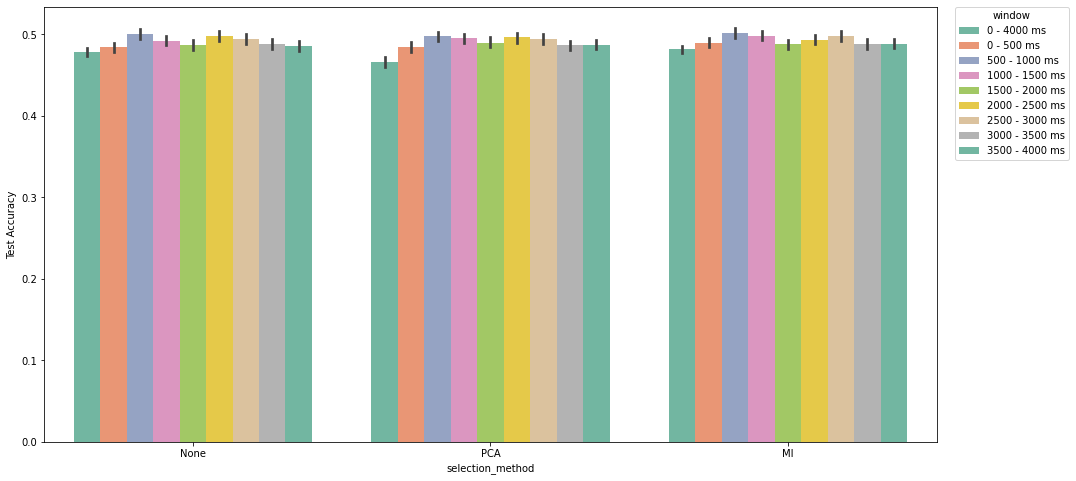

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
window_mapping = {
    'all': '0 - 4000 ms',
    '0': '0 - 500 ms',
    '1': '500 - 1000 ms',
    '2': '1000 - 1500 ms',
    '3': '1500 - 2000 ms',
    '4': '2000 - 2500 ms',
    '5': '2500 - 3000 ms',
    '6': '3000 - 3500 ms',
    '7': '3500 - 4000 ms'
}
plot_df = df.copy()
plot_df['window'].replace(window_mapping, inplace=True)

sns.barplot(data=plot_df, x='selection_method', y='Test Accuracy', hue='window', palette='Set2', ax=ax)
plt.legend(title='window', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);

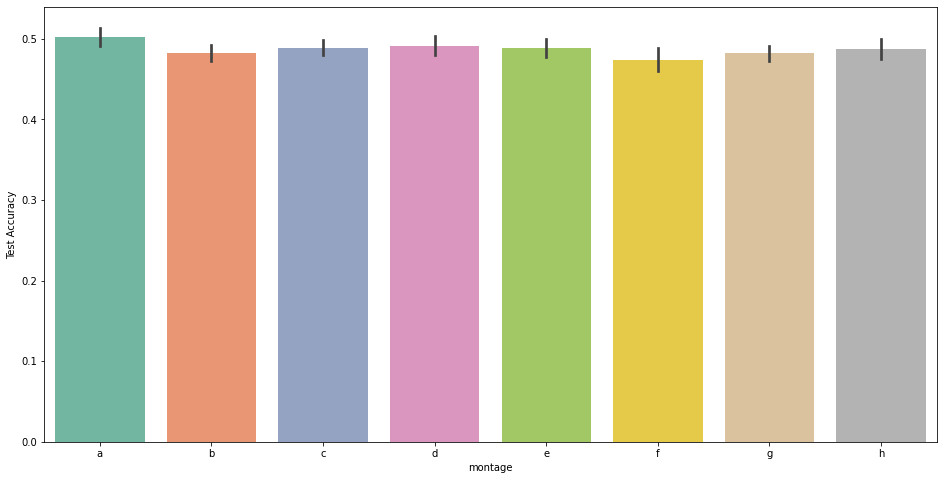

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], x='montage', y='Test Accuracy', palette='Set2', ax=ax);

In [20]:
save_performance_table(df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], 'Test Accuracy', output_table_dir, fname)